#**Notebook - Hidrologia** 

Nome: Julia da Silva Godinho (juliagodinho08@gmail.com)

---


Nesse notebook será criada uma função para o cálculo da evapotranspitação usando o método de PenmanMonteith-FAO, entre outras funções voltadas para conceito hidrológicos que serão usadas no desenvolvimento do trabalho de conclusão de curso. 

**Referência**: [Roteiro de cálculo da ETo](https://ainfo.cnptia.embrapa.br/digital/bitstream/CNPUV/8815/1/cir065.pdf)
[Trabalho de Hidrologia](https://drive.google.com/file/d/1DY97XNRTDGImE8K7iP4qqPtnJE1sNoPZ/view?usp=sharing)

**Funções**:
- `SaldoRadicao` estimativa do saldo de radiação Rn
- `Funcao_Eto` estimativa da Evapotranspiração de Referência ETo
- `Eto_plot` faz a plot da evapotranspiração
- `pluvio_media` faz a média aritimética das estações pluviométricas
- `hidrograma` plota a resposta chuva x vazão do canal

##Importando dados e bibliotecas

In [ ]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importando o notebook funcoes_preprocessamento

[Tutorial 1](https://www.pingshiuanchua.com/blog/post/importing-your-own-python-module-or-python-file-in-colaboratory) - [Tutorial 2](https://stackoverflow.com/questions/20186344/ipynb-import-another-ipynb-file)

In [ ]:
# # código para importar módulos de outros notebook
######### COMENTAR QUANDO NO ESTIVER FAZENDO TESTE
# %cd "/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC "
# !pip install import-ipynb
# import import_ipynb
# from PreProcessamento import *

/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC 


In [ ]:
# Os caminhos de cada arquivo
PillerArquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Arquivos CSV/chuvas_C_02242003.csv'
GaldiArquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Arquivos CSV/chuvas_C_02242004.csv'
SaoJoaoArquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Arquivos CSV/chuvas_C_02242005.csv'
OratorioArquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Arquivos CSV/Pluvio 2241004 Fazenda Oratorio.csv'
PillerFluArquivo = '/content/drive/MyDrive/IC - Aprendizado de Máquina/Arquivos CSV/vazoes_C_59135000.csv'
GaldiFluArquivo = '/content/drive/MyDrive/IC - Aprendizado de Máquina/Arquivos CSV/vazoes_C_59125000.csv'

In [ ]:
# Abrindo os arquivos
data_piller = pd.read_csv(PillerArquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';') 
data_galdi = pd.read_csv(GaldiArquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';') 
data_saojoao = pd.read_csv(SaoJoaoArquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';') 
data_orator = pd.read_csv(OratorioArquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';') 
data_flu_piller = pd.read_csv(PillerFluArquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';')
data_flu_galdi = pd.read_csv(GaldiFluArquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';')

# **1.Cálculo da Evapotranspiração**

**Variáveis necessárias**

Para o cálculo da ETo, é necessário que a estação forneça os seguintes dados diários:

- `T`  Temperatura do ar (C)
- `U2` Velocidade de vento a 2m de altura (m/s)
- `UR` Umidade relativa do ar (%) 
- `Rn ou RL` Saldo de Radiação (MJ/m2dia) **[ESTIMADA]**


## **1.1 Estimatica da Radiação Líquida (Rl)**

Função retorna o DataFrame com nova coluna com a estimativa do *Radiação Líquida (Rl)*.

**Parâmetros**:
- `df` o DataFrame 
- `Tmax` temp máxima do dia
- `Tmin` temp mínima do dia 
- `z` altitude (m)
- `lat` latitude (rad)
- `dia` dia em datetime

In [ ]:
def radiacao_liquida(df,Column_Tmax,Column_Tmin,z,lat):

  '''Função retorna o df com nova coluna a Radiação Líquida (Rl)
  e um df com os resultados dos cálculos feitos nessa função. 
  LEMBRAR: latitude em radianos e dia em datetime
  Atualizado'''

  # Criando um novo dataframe que terá os resultados nesse procedimento
  df_Rn = pd.DataFrame(index=df.index)

  # 1 Convertendo a data em dia Juliano 
  J = df.index.dayofyear
  df_Rn['J'] = J

  # 2 Radiação líquida (Rl)
  
  # 2.1 distancia inversa sol-terra
  dr = 1 + 0.033 * np.cos(2*np.pi*J/365)
  df_Rn['dr'] = dr

  # 2.2 declinacao solar
  declinacao = 0.409 * np.sin((2*np.pi*J/365) - 1.39)
  df_Rn['Declinacao'] = declinacao

  # 2.3 Angulo horário ao nascer do Sol 
  X = 1 - ((np.tan(lat)**2) * (np.tan(declinacao)**2))
  angulo = np.pi/2 - np.arctan(-np.tan(lat) * np.tan(declinacao) / (np.sqrt(X)))

  df_Rn['angulo_sol'] = angulo
    
  # 2.4 Radiação solar no topo da atmosfera (Ra ou Stop)
  Stop = (118.08/np.pi) * dr * (angulo*np.sin(lat)*np.sin(declinacao) + np.cos(lat)*np.cos(declinacao)*np.sin(angulo))
  df_Rn['S_TOP'] = Stop

  # 2.5 Radiação no topo da superfície (Ssup)
  Ssup = 0.19*Stop*np.sqrt(Column_Tmax-Column_Tmin)
  df_Rn['S_SUP'] = Ssup

  # 2.6 Radiação solar líquida (Rl)
  Rl = Ssup*(1 - 0.23)
  df_Rn['RL'] = Rl
  
  # Armazenando os resultados em uma nova coluna 
  df['Radiacao liquida'] = Rl

  return (df,df_Rn) 

## Teste

In [ ]:
# # Variáveis para a estimativa da Radiação Líquida
# T_max = 'TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)'
# T_min = 'TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)'
# z = 28        #altitude
# lat = -0.39   #latitude

# # A função retorna o df original e um novo com os resultados dos calculos
# data_macae, RL_Macae = radiacao_liquida(data_macae,data_macae[T_max],data_macae[T_min],z,lat)

# data_macae.head(3)

,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)","TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)","TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)","TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)",Radiacao liquida
Data Medicao,,,,,,,
2006-10-31,77.0,27.680645,22.732930,19.951613,81.366936,3.347715,16.380604
2006-11-30,170.6,28.003333,23.461359,20.903333,83.870729,3.206580,16.471009
2006-12-31,130.2,30.306452,25.279779,22.200000,80.461317,3.015600,17.757007


In [ ]:
# Macae_Arquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Climático/dados_A608_D_2006-09-21_2020-04-01.csv'
# df_macae = pd.read_csv(Macae_Arquivo,index_col=False,skiprows=10,encoding='latin-1',sep=';') 

# # As colunas de interesse 
# colunas_macae = ['PRECIPITACAO TOTAL, DIARIO (AUT)(mm)','TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)',
#            'TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)','TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)',
#            'UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)','VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)']

# # Mudando o formato da datas de medição
# # para ficarem compatíveis com as previstas na função de preprocessamento
# df_macae['Data Medicao'] = pd.to_datetime(df_macae['Data Medicao'],format='%Y/%m/%d')

# # Fazendo o preprocessamento dos dados
# data_macae = preprocessamento(df_macae,colunas_macae,'Data Medicao',
#                               'Automática Macae', inicio = '10-2006',
#                               fim = '03-2020', eto = True)



A estação Automática Macae tem 162 observações com frequencia mensal de 31-10-2006 até 31-03-2020


##**1.2 Cálculo dos coeficientes**

Além das variáveis medidas pela estação, precisamos calcular os seguintes coeficientes:

- `Delta(T)`
- `Gama(Patm,z)` 
- `es(T)` pressão de saturação de vapor (kPa)
- `ea(UR)` pressão atual de vapor (kPa)

###**Cálculo do Delta**

In [ ]:
def Funcao_Delta(T):
  delta_1 = 4098*(0.6108*np.exp((17.27*T)/(T+237.3)))
  delta_2 = (T+237.3)**2
  
  delta = delta_1/delta_2

  return delta

###**Cálculo do gama**

In [ ]:
def Funcao_Gama(z):

  #Patm - pressão atmosférica local (kPa)
  Patm = 101.3*(((293 - 0.0065*z)/293)**5.26)

  #gama
  gama = 0.665*(10**(-3))*Patm

  return gama

###**Cálculo do déficit de saturação**

Dado pela diferença entre *es* a *ea*

In [ ]:
def Funcao_Deficit(T,UR):

  es = 0.6108 * np.exp(17.27*T/(T+237.3))

  ea = es*UR/100

  deficit = es - ea

  return deficit

##**1.3 Estimativa Evapotranspiração de Referência (Eto)**

Caso não tenha o valor de G, considera-lo *zero*.

In [ ]:
def Funcao_Eto (df,T,UR,U2,Rl,z):

  '''Função retorna um DataFrame com os resulatdos dos cálculos
  da evapotranspiração diária'''

  # Criando um novo dataframe
  df_Eto = pd.DataFrame(index = df.index)

  # Calculo do delta
  delta = Funcao_Delta(T) 
  df_Eto['delta'] = delta

  # Calculo do gama
  gama = Funcao_Gama(z) 
  df_Eto['gama'] = gama

  # Calculo do deficit de saturação
  deficit = Funcao_Deficit(T,UR)
  df_Eto['deficit'] = deficit

  # Calculo da ETo diario
  Eto_1 = 0.408*delta*Rl 
  Eto_2 = gama*900*U2*deficit/(T+237)
  Eto_3 = delta + gama*(1+0.34*U2)

  Eto = (Eto_1 + Eto_2)/Eto_3

  df_Eto['ETo_diario'] = Eto

  # Calculo da ETo mensal 
  dias_mes = df.index.days_in_month
  df_Eto['ETo_mensal'] = Eto*dias_mes

  return df_Eto

# **2.Plotagem com a função `Eto_plot`**

Parâmetros:
- `df` 
- `coluna` que possui os valores a serem plotados

In [ ]:
def Eto_plot(df,coluna):

  '''Função faz o plot da ETo, comparando os valores de cada ano'''

  # criando uma lista com os anos de observação 
  anos = list(df.index.year)
  anos = set(anos)

  # plotando o grafico - cada ano será representado em uma linha 
  plt.figure(figsize=(9,5))

  for ano in anos:
    y = df[coluna][str(ano)]
    x = y.index.month
    plt.plot(x,y,label=ano)
    
  plt.legend(ncol=2,loc='center right',bbox_to_anchor=(1.4,0.5))
  plt.xlabel('Meses')
  plt.ylabel('Evapotranspiração mensal (mm/mes)')
  plt.title('Evapotranspiração')
  plt.show()


##**Teste**

Abrindo uma planilha da estação automática Macaé

In [ ]:
# Arquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Climático/dados_A608_D_2006-09-21_2020-04-01.csv'
# data = pd.read_csv(Arquivo,index_col=False,skiprows=10,encoding='latin-1',sep=';')

# #definindo as colunas de interesse
# colunas_dados = ['PRECIPITACAO TOTAL, DIARIO (AUT)(mm)',
#        'PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)',
#        'TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(Â°C)',
#        'TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)',
#        'TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)',
#        'TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)',
#        'UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)',
#        'VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)']

# data['Data Medicao'] = pd.to_datetime(data['Data Medicao'],format='%Y/%m/%d')

#data = preprocessamento(data,colunas_dados,'Data Medicao',"Macae")
#data.head(3)

Usando a função de cálculo da Radiação Líquida `RadiacaoLiquida`

In [ ]:
# Tmax = 'TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)'
# Tmin = 'TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)'
# z = 30
# lat = -0.39
# #data_Rn,df_Rn = RadiacaoLiquida(data,data[Tmax],data[Tmin],z,lat)
# #df_Rn.head(3)

Fazendo o cálculo da ETo usando `Funcao_ETo`

In [ ]:
# T = 'TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)'
# UR = 'UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)'
# U2 = 'VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)'
# Rl = 'Radiacao liquida'


# #df_eto = Funcao_Eto(data_Rn,data_Rn[T],data_Rn[UR],
#                     #data_Rn[U2],data_Rn[Rl],z)
# #df_eto.head(3)

,delta,gama,deficit,ETo_diario,ETo_mensal
Data Medicao,,,,,
2006-09-30,0.153402,0.067129,0.476668,4.077791,122.333745
2006-10-31,0.167538,0.067129,0.515088,4.502434,139.575462
2006-11-30,0.174101,0.067129,0.465942,4.358875,130.766243


# **3.Precipitação média**

[Apostila](http://www.ufrrj.br/institutos/it/deng/leonardo/downloads/APOSTILA/HIDRO-Cap4-PPT.pdf)




##Método aritimético 

É o método mais simples e consiste em se determinar a média aritmética entre as quantidades medidas na área. 

Esse método só apresenta boa
estimativa se os aparelhos forem distribuídos uniformemente e a área for plana
ou de relevo muito suave. 

É necessário também que a média efetuada em cada
aparelho individualmente varie pouco em relação à média

In [ ]:
def pluvio_media (df,colunas):

  '''Essa função retorna o df com uma nova coluna com a precipitação média 
  calculada pelo método aritimético.

  É necessário informar o dataframe que reuna todas as estacoes.'''

  df['Media'] = df[colunas].mean(axis=1)

  return (df)

In [ ]:
# df_teste = pd.DataFrame()
# df_teste['Estacao 1']=[1,3,2,5,5,6]
# df_teste['Estacao 2']=[4,6,2,3,7,8]
# df_teste['Estacao 3']=[4,6,2,6,8,4]
# #df_teste

# #df2 = media_aritimetica(df_teste,['Estacao 1','Estacao 2','Estacao 3'],)
# #df_teste

#**4.Curva Dupla-Massa**

In [ ]:
def dupla_massa(df,colunas):

  '''Essa função retorna um gráfico de dupla-massa. 
  Onde o eixo X é o total acumulado no posto, e o eixo Y é a média acumulada'''

  dupla_m = pd.DataFrame()

  for estacao in colunas:

    dupla_m[estacao] = df[estacao].cumsum()
  
  print(dupla_m)


# **5.Hidrograma**

In [ ]:
def hidrograma (df_flu, df_plu, size = (13,4), legend_loc = "center right",
                flu_ylim = 700, plu_ylim = 150, flu_ylabel = "COTA (cm)", width = 10):

  '''Essa função recebe dados de vazão e precipitação e retorna o hidrograma.
  
  - size: valor em tupla. default (13,4)
  - location: default "center right" '''
  
  plt.style.use('seaborn-paper')

  fig, ax =  plt.subplots(figsize = size)

  # VAZAO - COTA    
  ax.plot(df_flu, color ='blue', lw = 0.6)
  ax.set_ylim(0,flu_ylim)
  ax.set_ylabel(flu_ylabel)
  ax.set_xlabel("DATA")

  # CHUVA 
  ax_plu = ax.twinx()

  ax_plu.bar(df_plu.index, df_plu, color = 'red', width = width)
  ax_plu.set_ylim(0,plu_ylim)
  ax_plu = plt.gca().invert_yaxis()
  plt.ylabel("PRECIPITAÇÃO (mm)")

  #LEGENDAS
  leg_flu = mlines.Line2D([], [], color='blue', markersize=15, label='Vazão')
  leg_plu = mlines.Line2D([], [], color='red', markersize=15, label='Precipitação')
  plt.legend(handles=[leg_flu, leg_plu], loc = legend_loc)

  plt.title("HIDROGRAMA", pad = 7)
  path = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Plots/Hidrograma.jpeg'  
  plt.savefig(fname = path, bbox_inches='tight', pad_inches=0.1, dpi = 150)
  plt.show()

##**Teste**

In [ ]:
# col_mensal = ['Total','NumDiasDeChuva']
# col_flu_mensal = ['Maxima','Media']
# #col = data_piller.columns[13:44] #para dados diários - CHUVA
# #col_flu = data_flu_piller.columns[16:47]

# pluvio_diario = preprocessamento(data_galdi, colunas_dados = col_mensal,
#                              coluna_index = "Data",
#                              nome_estacao = "Galdi", freq = 'mensal', 
#                              inicio = '2005', fim = '2011')

# fluvio_diario = preprocessamento(data_flu_galdi, colunas_dados = col_flu_mensal,
#                              coluna_index = "Data",
#                              nome_estacao = "Galdi", freq = 'mensal', 
#                              inicio = '2005', fim = '2011')

# #pluvio_diario  = KNN(pluvio_diario, col_mensal)
# #fluvio_diario = KNN(fluvio_diario, col_flu_mensal)

# hidrograma(fluvio_diario["Media_KNN"], pluvio_diario["Total_KNN"], flu_ylim=50, plu_ylim= 800)

A estação Galdi tem 84 observações com frequencia mensal de 31-01-2005 até 31-12-2011
A estação Galdi tem 84 observações com frequencia mensal de 31-01-2005 até 31-12-2011


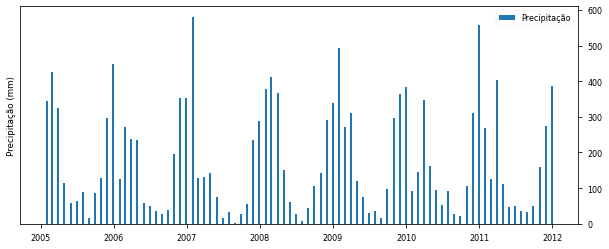

In [ ]:
# fig, ax = plt.subplots(figsize=(10,4))
# ax.yaxis.tick_right()
# #plt.plot(fluvio_diario,label='Vazão')
# plt.bar(x = pluvio_diario.index, height = pluvio_diario['Total_KNN'], 
#         width=10, label = "Precipitação")
# plt.legend()
# plt.ylabel("Precipitação (mm)")
# plt.show()

# **6.Curva de Permanência**

In [ ]:
def CurvaPermanencia(df,coluna):

  '''Essa função retorna a curva de permanência para a estação e no período informado'''

  linhas = df.shape[0]

  # 1 - Criando um novo dataframe
  curva_permanencia = pd.DataFrame()
  curva_permanencia['Vazoes'] = df[coluna].values

  # 2 - Calculando a frequencia de ocorrencia de cada vazao
  curva_permanencia['Frequencia_1'] = curva_permanencia.index
  curva_permanencia['Frequencia'] = curva_permanencia['Frequencia_1'].apply(lambda x : ((x+1)/linhaas)*100)
  curva_permanencia.drop(columns=['Frequencia_1'],inplace=True)

  # 3 - Plotando a curva de permanência
  curva_permanencia.plot(x='Frequencia',y='Vazoes',figsize=(12,4),title='Curva de Permanência')
  plt.ylabel('Vazão (m³/s)')
  plt.xlabel('Frequência (%)')
  plt.show()
